# **CT SCAN IMAGE CLASSIFICATION**

[68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667.svg](https://colab.research.google.com/drive/1aXTv0m3hq70NK9L4z7KjpU5hqplAtxeh#scrollTo=xu6ovtvd97jA)

### IMPORTING DATA

To import dataset, Connect to Google Drive to access Dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/CAPSTONE PROJECT'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CAPSTONE PROJECT


**IMPORTING ESSENTIAL LIBRARIES**

In [ ]:
import os
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

**LOADING DATA AND PREPROCESSING**

This dataset contains 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19)
and 1229 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. This data is in the form of images.

In [ ]:
#define paths for loading data
covid_path = '/content/drive/MyDrive/CAPSTONE PROJECT/COVID'
noncovid_path = '/content/drive/MyDrive/CAPSTONE PROJECT/non-COVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

#define size to which images are to be resized

IMAGE_SIZE = [80, 80]



In [ ]:
#Total count of data
print("Total Count of Covid data : ",len(covid_files))

print("Total Countof Non-covid data : ",len(noncovid_files))

Total Count of Covid data :  1252
Total Countof Non-covid data :  1229


###**RESIZE IMAGES**

Setting the image sizeSetting the image size to H=80 and W=80 standardizes all images to the same dimensions, ensuring compatibility with model requirements and efficient batch processing. This prevents bias and simplifies dataset management.


Fetch Images and Class Labels from Files. This might take saveral minutes.

In [ ]:
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])               # read file
  image = cv2.resize(image,(80,80))                # resize as per model for covid
  covid_images.append(image)                       # append image
  covid_labels.append('COVID')                     #append class label

for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.resize(image,(80,80))
  noncovid_images.append(image)
  noncovid_labels.append('non-COVID')

**Visualize First few images from dataset**

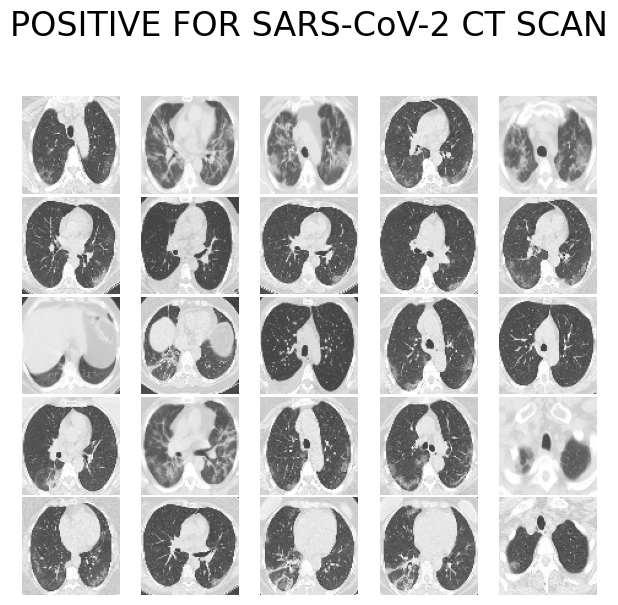

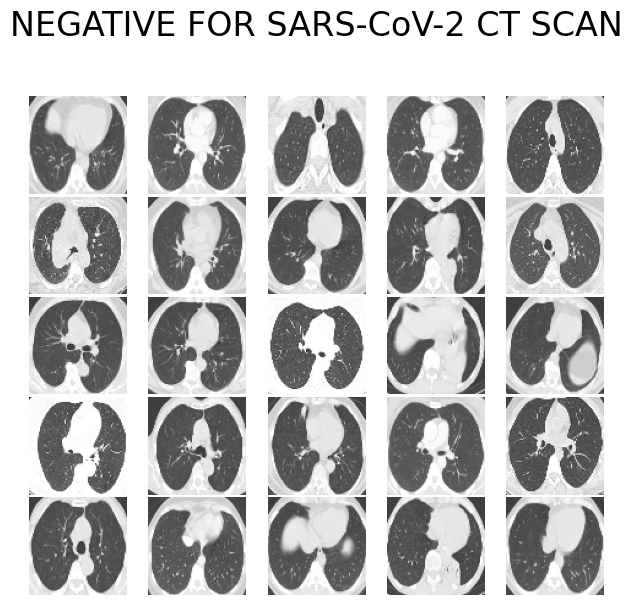

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 5
    figsize = [6, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'POSITIVE FOR SARS-CoV-2 CT SCAN')
plot_images(noncovid_images, 'NEGATIVE FOR SARS-CoV-2 CT SCAN')

**NORMALIZATION**

Model takes images in the form of array of pixels. Convert images into array and normalize.

In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

**BUILD TRAIN AND VALIDATION DATASET**



In [ ]:
# Split into training and testing sets for both types of images

covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2, random_state=1)

noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2, random_state=1)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)                                     # y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

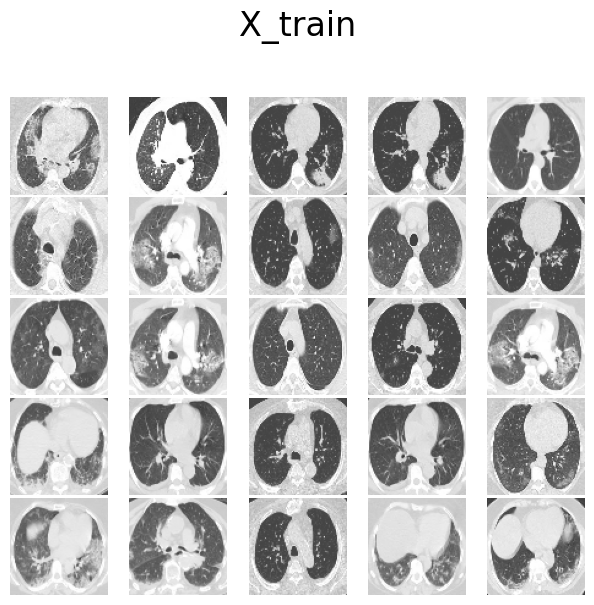

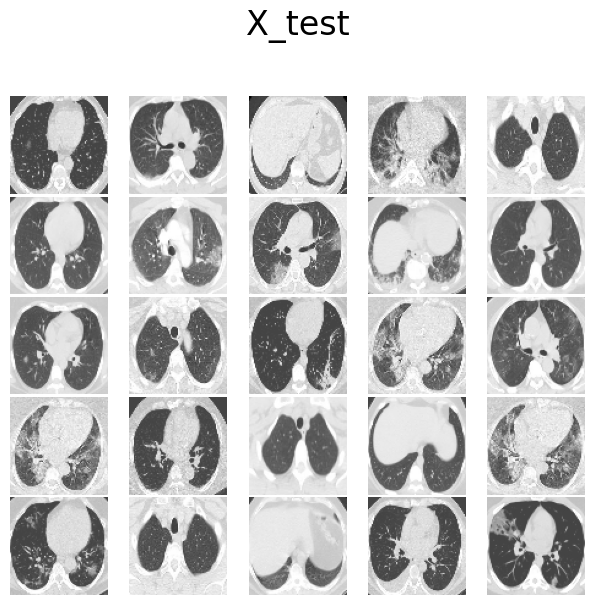

X_tain: 1984
X_test: 497


In [ ]:
# Visualize images from training and test set

plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

print("X_tain:", X_train.shape[0])   #checking size of array
print("X_test:", X_test.shape[0])

**DATA AUGMENTATION**

In [ ]:
datagen = ImageDataGenerator(rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)


###**MODEL BUILDING USING ResNet50**

ResNet Model
ResNet is an upgraded version of the ResNet architecture, which is a deep convolutional neural network (CNN). It incorporates improvements to the original ResNet model by optimizing the residual block structure, resulting in better training convergence and accuracy. Like its predecessor, ResNet is trained on the ImageNet dataset, a large collection of labeled images, to learn features that can be transferred to various computer vision tasks. It utilizes skip connections and residual blocks to enable training of very deep networks, mitigating the vanishing gradient problem and facilitating the training of deeper architectures.

In [ ]:
# Building Model
from tensorflow import keras
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(80, 80, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(2, activation="sigmoid")(outputs)

model = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = False

model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=['accuracy']
)
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'model_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()  #builing model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 86, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 40, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 40, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

**TRAINING THE MODEL**

In [ ]:
batch_size=2
epochs=30

hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                  validation_data=(X_test, y_test),
                  validation_steps=len(X_test) / batch_size,
                  steps_per_epoch=len(X_train) / batch_size,
                  epochs=epochs,callbacks=[early_stopping, model_checkpoint]
                 )

Epoch 1/30
992/992 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.5912
Epoch 1: val_loss improved from inf to 0.53990, saving model to model_checkpoint.h5
992/992 [==============================] - 111s 108ms/step - loss: 0.7054 - accuracy: 0.5912 - val_loss: 0.5399 - val_accuracy: 0.7364
Epoch 2/30
992/992 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5938
Epoch 2: val_loss did not improve from 0.53990
992/992 [==============================] - 97s 97ms/step - loss: 0.6974 - accuracy: 0.5938 - val_loss: 0.6363 - val_accuracy: 0.6298
Epoch 3/30
992/992 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.6265
Epoch 3: val_loss did not improve from 0.53990
992/992 [==============================] - 100s 101ms/step - loss: 0.6760 - accuracy: 0.6265 - val_loss: 0.5796 - val_accuracy: 0.6942
Epoch 4/30
992/992 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.6200
Epoch 4: val_loss did not improve f

In [ ]:
# Save Model and Weights

model.save('resnet_ct.h5')
model.save_weights('resnet_weights_ct.hdf5')

In [ ]:
# Load saved model

model = load_model('resnet_ct.h5')
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 14s 790ms/step - loss: 0.5399 - accuracy: 0.7364
Final Loss: 0.5398971438407898, Final Accuracy: 0.7364184856414795


**MAKING PREDICTION**

In [ ]:
y_pred = model.predict(X_test,batch_size=batch_size)

249/249 [==============================] - 20s 76ms/step


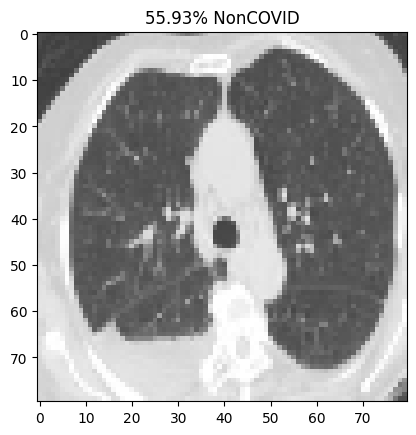

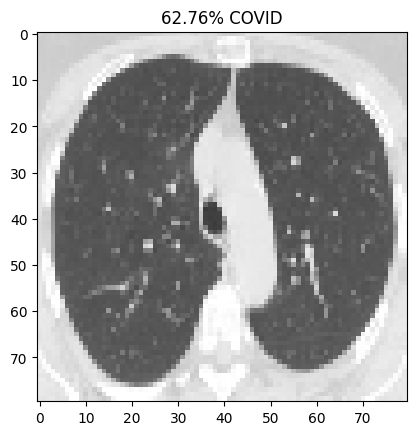

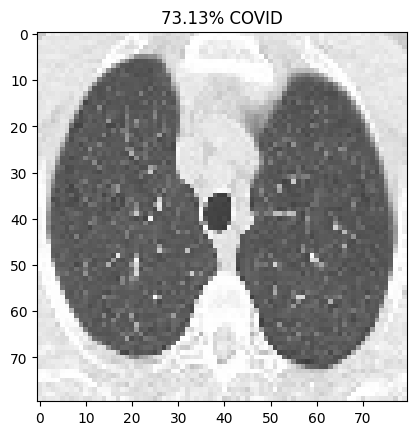

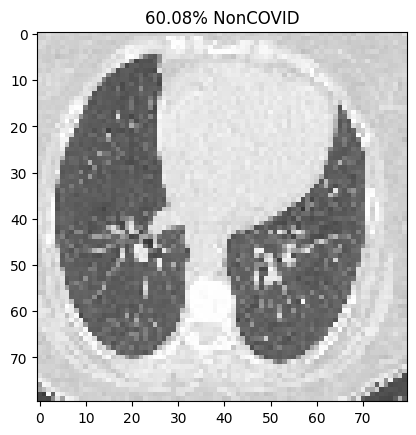

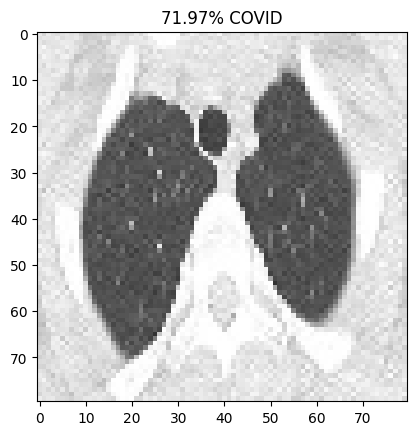

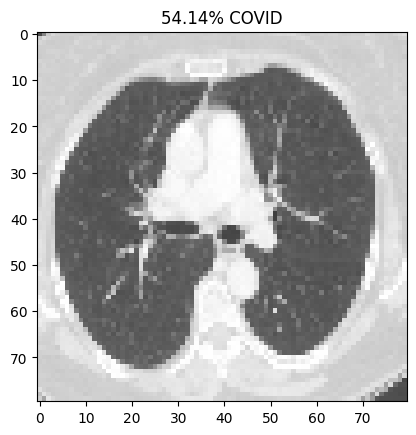

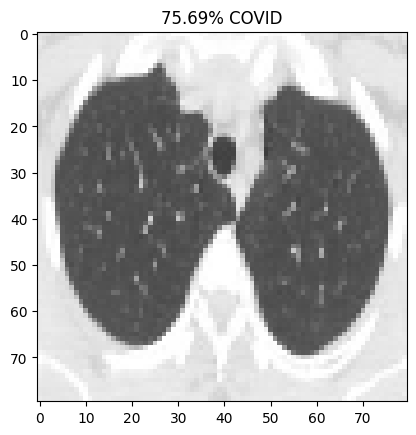

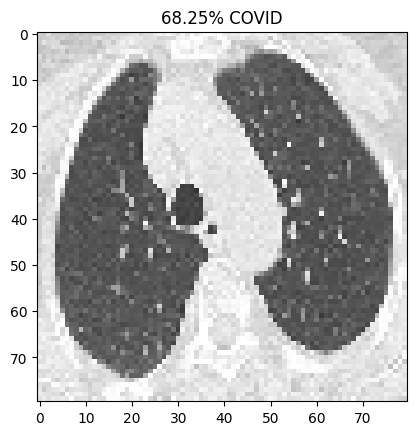

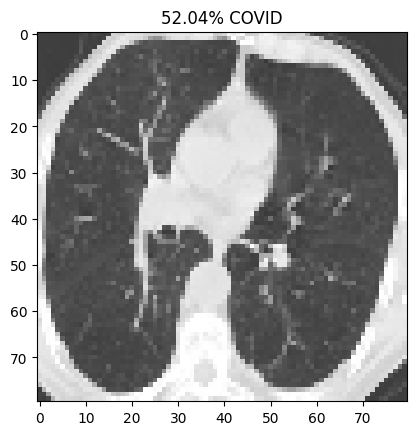

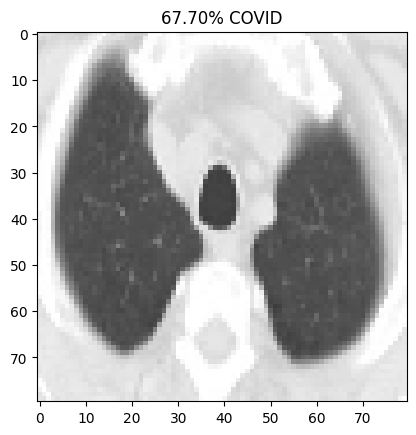

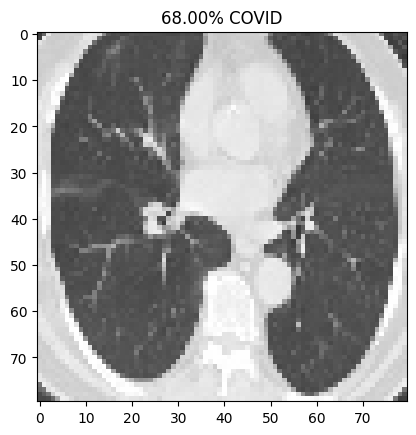

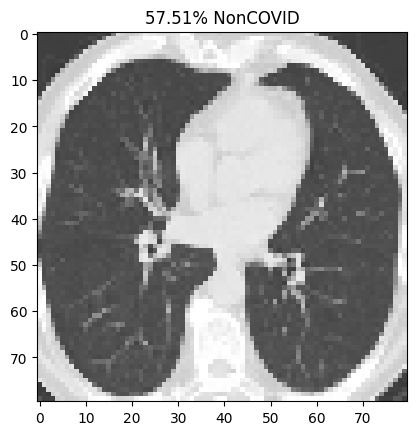

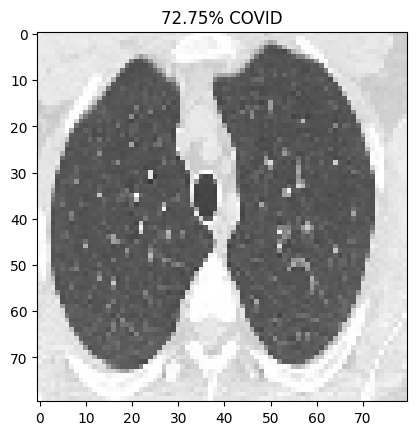

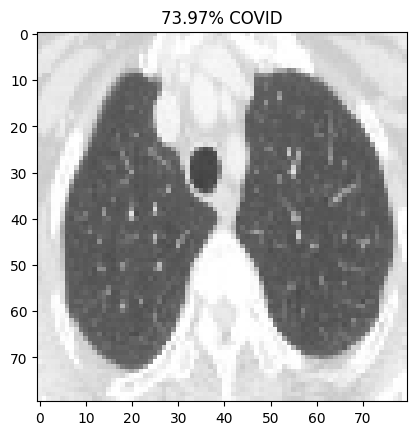

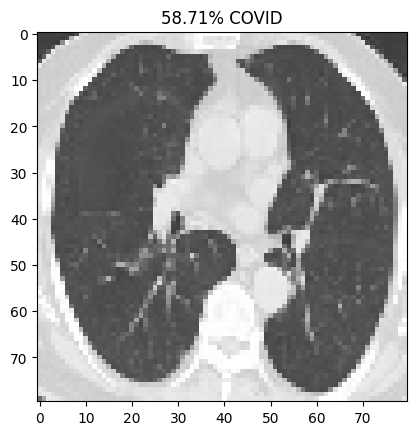

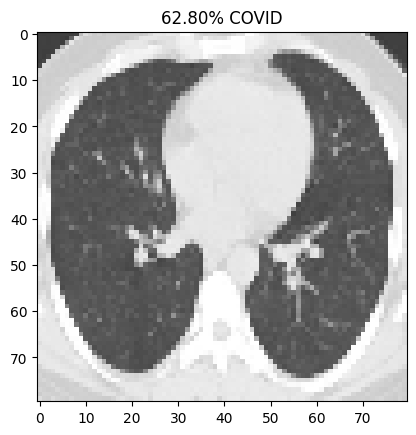

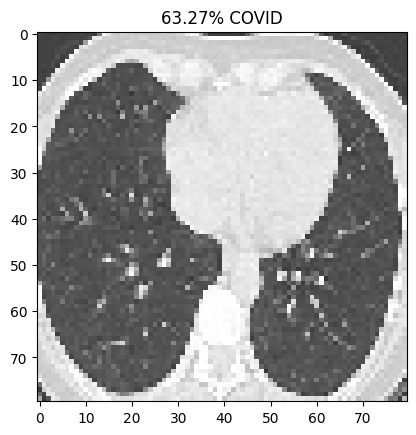

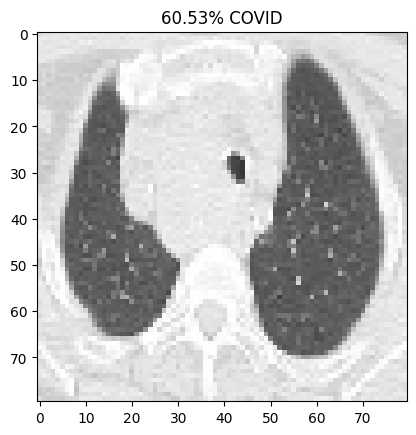

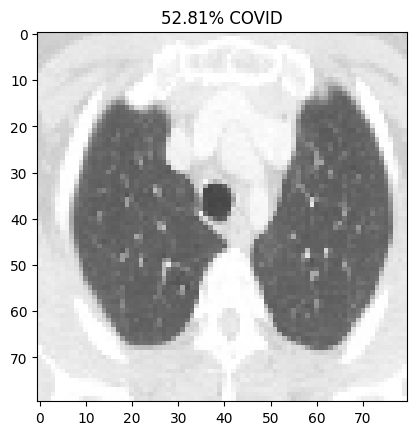

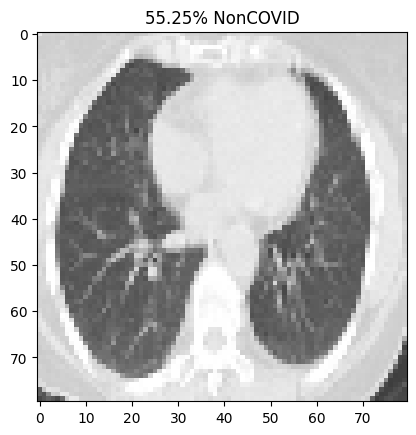

In [ ]:
prediction=y_pred[0:20]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)


**CLASSIFICATION REPORT**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin,y_pred_bin))

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       251
           1       0.70      0.80      0.75       246

    accuracy                           0.74       497
   macro avg       0.74      0.74      0.74       497
weighted avg       0.74      0.74      0.74       497



**CREATING CONFUSION MATRIX**

Confusion Matrix with Normalized Values


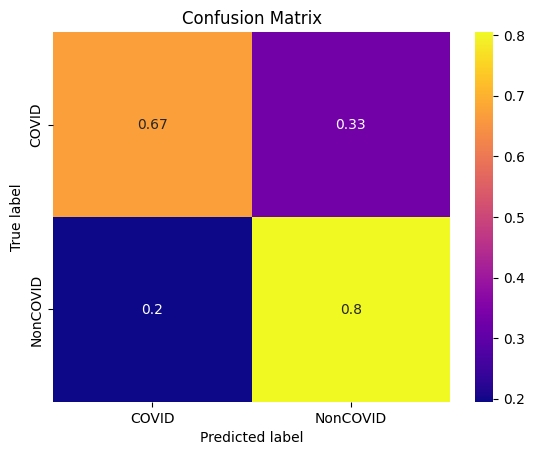

Confusion Matrix without Normalization


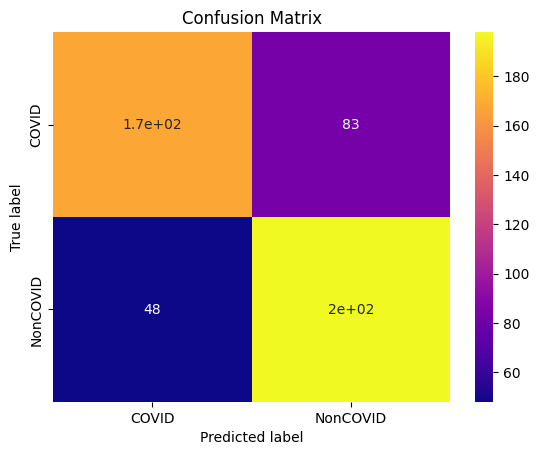

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

**ROC CURVE**

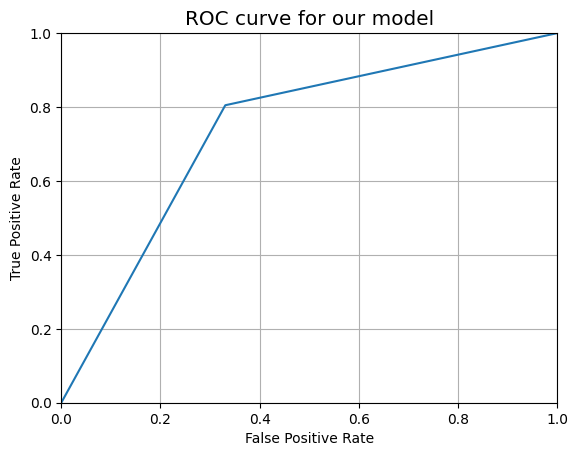

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

##**Visualizing model performance**
Here the model accuracy and loss for the training and the validation sets are plotted. Since the validation set is class-balanced, accuracy provides an unbiased representation of the model's performance.

**MODEL ACCURACY PLOT**

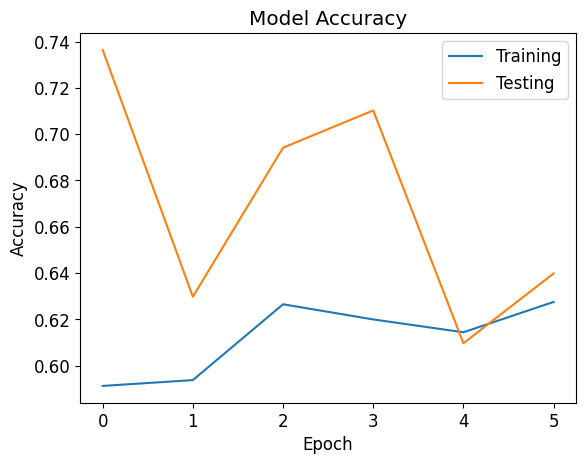

In [ ]:
#let's see accuracy plot

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_accuracy.png')
plt.show()

**MODEL LOSS PLOT**

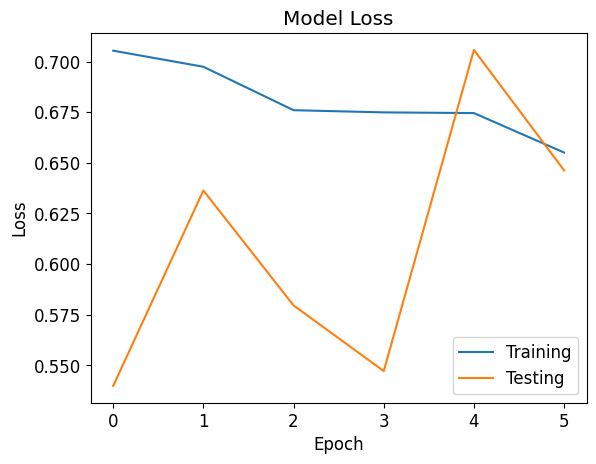

In [ ]:
# let's see model loss plot


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_loss.png')
plt.show()